In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np

In [2]:
# os.system("aws --region us-west-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region us-west-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")

In [3]:
# time.sleep(40)

In [4]:
with open('all_external_ips') as f:
    lines = f.read().splitlines()


lines = [x for x in lines if x!='None']
lines

for ip in lines:
    if ip!='None':
        current = (ip.split('.'))

        print('ssh -i "MAKWest.pem" ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-

## Set number of clusters

In [5]:
nclusters = 0

for folder in os.listdir('.'):
    if 'config' in folder and folder!='config':
        nclusters = nclusters + 1
        
        
print(nclusters)


total_count = 12


nreplicas = int(total_count/nclusters)
nodeIps = lines[:nclusters* nreplicas]

nclients = 3

# no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]




# clientIps = lines[-(nclusters):]
clientIps = lines[-nclients:]



3


In [6]:
clientIps, no_cluster_yet_nodes

(['127.0.0.1', '127.0.0.1', '127.0.0.1'], [])

## Functions

In [7]:
def setup(i):

    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:commands.sh'
        
        
        os.system(command)

        
def compile_job(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S ./gradlew installDist'
        
        
        os.system(command)

        
        
def clean_job(i):
    ip = lines[i]
    
#     rm_command = 'sudo rm config/currentView; '
#     for iter_ in range(nclusters):
#         rm_command = rm_command + 'rm config'+str(iter_)+'/currentView; '
        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S rm ../dump_files/nohup*.out; echo 1234 | sudo -S rm config*/currentView;'
        
        
        os.system(command)
        
        

        
def run_server_node(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../dump_files/nohup_s'+str(i)+'.out 2>&1 & echo $! > ../dump_files/jobID_s'+str(i)+'.txt'
        
        
        os.system(command)
        
        
        
    if ip!='None' and( ip in no_cluster_yet_nodes):
        
        current = (ip.split('.'))
        command = 'nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../dump_files/nohup_s'+str(i)+'.out 2>&1 &'
        
        
        os.system(command)        
#         print(command)



def run_basic_client(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
#     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
        current = (ip.split('.'))
        
#         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'nohup ./runscripts/ycsbClient.sh '+str(i-len(nodeIps)-len(no_cluster_yet_nodes))+' >../dump_files/nohup_c'+str(i)+'.out 2>&1 &'

        
        os.system(command)


def kill_java(i):
    ip = lines[i]
    
    if ip!='None':
        current = (ip.split('.'))
        command = ' killall java; killall nohup'
        
        
        os.system(command)
        
        
        
def kill_clients(i):
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        current = (ip.split('.'))
        command = 'killall java;  killall nohup"'
        
        
        os.system(command)

def run_server_node_check(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = ' nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../dump_files/nohup_s'+str(i)+'.out 2>&1 &'
        
        
        print(command)
        
        

# for i in range(len(lines)):
#     run_server_node_check(i)

def run_basic_client_check(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../dump_files/nohup_c'+str(i)+'.out 2>&1 &'

        
        print(command)

# for i in range(len(lines)):
#     run_basic_client_check(i)



def join_node1(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices '+str(i)+' 127.0.0.1 11080 11081 config0 >../dump_files/nohup_j'+str(i)+'.out 2>&1 &'
        
        
        os.system(command)   
        
        
def join_node2(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices '+str(i)+' 127.0.0.1 11090 11091 config0 >../dump_files/nohup_j'+str(i)+'.out 2>&1 &'
        
        
        os.system(command) 
        
def join_node3(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices '+str(i)+' 127.0.0.1 11100 11101 config0 >../dump_files/nohup_j'+str(i)+'.out 2>&1 &'
        
        
        os.system(command) 

## Compile Job

## Setup Client and nodeIPS

In [8]:
len(lines)

15

In [9]:
len(nodeIps), len(clientIps)

(12, 3)

## RUN SERVERS

In [10]:
for i in range(len(lines)):
    kill_java(i)

for i in range(len(lines)):
    clean_job(i)
    
compile_job(1)



java(9903): Operation not permitted
java(10728): Operation not permitted
java(12083): Operation not permitted
java: no process found
nohup: no process found
java(9903): Operation not permitted
java(10728): Operation not permitted
java(12083): Operation not permitted
java: no process found
nohup: no process found
java(9903): Operation not permitted
java(10728): Operation not permitted
java(12083): Operation not permitted
java: no process found
nohup: no process found
java(9903): Operation not permitted
java(10728): Operation not permitted
java(12083): Operation not permitted
java: no process found
nohup: no process found
java(9903): Operation not permitted
java(10728): Operation not permitted
java(12083): Operation not permitted
java: no process found
nohup: no process found
java(9903): Operation not permitted
java(10728): Operation not permitted
java(12083): Operation not permitted
java: no process found
nohup: no process found
java(9903): Operation not permitted
java(10728): Operation

> Task :compileJava UP-TO-DATE
> Task :processResources NO-SOURCE
> Task :classes UP-TO-DATE
> Task :jar UP-TO-DATE
> Task :installDist UP-TO-DATE

BUILD SUCCESSFUL in 1s
3 actionable tasks: 3 up-to-date


In [11]:
    
for i in range(len(lines)-nclients-len(no_cluster_yet_nodes)):
    print(i)
    run_server_node(i)

0
1
2
3
4
5
6
7
8
9
10
11


In [12]:
time.sleep(30)
!tail ../dump_files/nohup_s0.out -n 50

-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- receiving, null msg:null
-- <-- r

In [13]:


# for i in range(len(lines)):
#     kill_java(i)

In [14]:
len(nodeIps)+len(no_cluster_yet_nodes)+len(clientIps)


15

## Run basic client

In [15]:
for i in range(len(nodeIps)+len(no_cluster_yet_nodes),len(nodeIps)+len(no_cluster_yet_nodes)+len(clientIps)):
    run_basic_client(i)

In [16]:
time.sleep(40)

In [17]:

# time.sleep(30)
# run_server_node(8)
# time.sleep(15)
# join_node1(8)

# time.sleep(30)
# run_server_node(9)

# time.sleep(30)
# join_node2(9)

# time.sleep(30)
# run_server_node(10)
# time.sleep(30)
# join_node3(10)

In [18]:
# time.sleep(50)

# run_server_node(9)

# time.sleep(160)
# join_node2(9)


# for i in [2]:
#     os.system('kill -9 `cat ../dump_files/jobID_s2.txt`')
    


# time.sleep(80)



for i in range(len(lines)):
    kill_java(i)
    


java(9903): Operation not permitted
java(10728): Operation not permitted
java(12083): Operation not permitted
nohup: no process found
java(9903): Operation not permitted
java(10728): Operation not permitted
java(12083): Operation not permitted
nohup: no process found
java(9903): Operation not permitted
java(10728): Operation not permitted
java(12083): Operation not permitted
nohup: no process found
java(9903): Operation not permitted
java(10728): Operation not permitted
java(12083): Operation not permitted
nohup: no process found
java(9903): Operation not permitted
java(10728): Operation not permitted
java(12083): Operation not permitted
nohup: no process found
java(9903): Operation not permitted
java(10728): Operation not permitted
java(12083): Operation not permitted
nohup: no process found
java(9903): Operation not permitted
java(10728): Operation not permitted
java(12083): Operation not permitted
nohup: no process found
java(9903): Operation not permitted
java(10728): Operation not

In [19]:
# for i in range(len(lines)):
#     kill_java(i)

## Main Job

In [20]:
def getTimesThputs(file):
    f = open(file, "r")
    data = f.readlines() 
    times = []
    thputs = []
    latencies = []
    for line in data:
        if not line.startswith('--') and 'current ops/sec; [UPDATE AverageLatency' in line:

#         print(line)
            times.append(line.split('sec:')[0].strip())
            thputs.append(line.split(';')[1].split('current')[0].strip())
            latencies.append(line.split('=')[1].split(']')[0].strip())

    return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)  






def getTimeThps(file, flag):
    
    f = open(file, "r")
    data = f.readlines() 

    times = []
    thputs = []
    for line in data:
        if 'throughput[ops/s]' in line:
            lineData = (line[13+line.find('max[ops/s])>'):-2])
            print(lineData)

            times.append(lineData.split('|')[0])
            thputs.append(lineData.split('|')[-2])
    if (flag): 
        times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
        thputs.append(0)
        
    return np.array(times).astype(float), np.array(thputs).astype(float) 


In [21]:
## Byzantine Remote View Change

In [22]:
times ,thputs, lats = getTimesThputs('../dump_files/nohup_c'+str(len(nodeIps)+len(no_cluster_yet_nodes))+'.out')
times2 ,thputs2, lats = getTimesThputs('../dump_files/nohup_c'+str(len(nodeIps)+len(no_cluster_yet_nodes)+1)+'.out')


'../dump_files/nohup_c'+str(len(nodeIps)+len(no_cluster_yet_nodes))+'.out'

'../dump_files/nohup_c12.out'

In [23]:
# times - times2

In [24]:
# thputs = thputs + thputs2

In [25]:
# np.mean(lats[20:]) # 23604.83205128205

In [26]:
np.mean(lats[20:])

3083385.0

In [27]:
lats

array([3774017.  , 6159769.08, 4265120.5 , 3310070.74, 3618842.55,
       2027136.28, 2042102.28, 1411493.  , 2736640.6 , 3746289.36,
       3679207.17, 2081657.  , 2646631.64, 2898913.92, 2166800.99,
       1947501.69, 1486357.5 , 2499416.84, 2617632.97, 3067301.79,
       3083385.  ])

In [28]:
# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput')

# # pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# # pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
# pl.show()
# pl.clf()


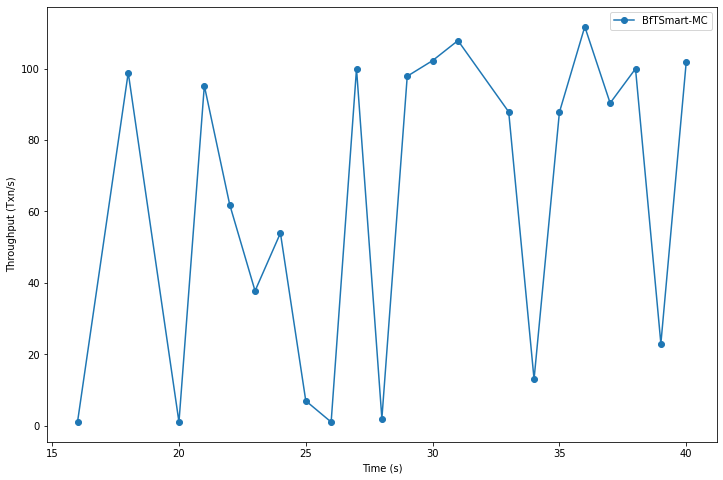

<Figure size 432x288 with 0 Axes>

In [29]:
import pylab as pl

pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Joins Throughput')

# pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
# pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
pl.show()
pl.clf()


In [30]:
(thputs), np.sum(thputs)

(array([  1.  ,  98.9 ,   1.  ,  95.24,  61.94,  37.75,  53.95,   6.94,
          1.  , 100.  ,   1.98,  97.9 , 102.28, 107.89,  87.91,  12.99,
         87.82, 111.78,  90.37, 100.  ,  22.98, 101.9 ]),
 1383.52)

In [31]:
# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Joins Throughput')

# # pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# # pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
# pl.show()
# pl.clf()
